## 0. Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)


## 1. Load the Data

In [2]:

players = pd.read_csv("player_data.csv")
stints = pd.read_csv("stint_data.csv")

players.head(), stints.head()


(   player  rating
 0  USA_p1     3.0
 1  USA_p2     3.0
 2  USA_p3     3.5
 3  USA_p4     0.0
 4  USA_p5     2.0,
    game_id h_team a_team   minutes  h_goals  a_goals   home1   home2   home3  \
 0        1    USA  Japan  4.252969        4        9  USA_p4  USA_p1  USA_p3   
 1        1    USA  Japan  5.688809        6       11  USA_p1  USA_p7  USA_p6   
 2        1    USA  Japan  1.149557        0        1  USA_p8  USA_p1  USA_p4   
 3        1    USA  Japan  3.511617        7        5  USA_p2  USA_p7  USA_p8   
 4        1    USA  Japan  2.163139        7        5  USA_p9  USA_p5  USA_p8   
 
     home4      away1      away2      away3      away4  
 0  USA_p6  Japan_p12   Japan_p4   Japan_p8   Japan_p6  
 1  USA_p5   Japan_p7  Japan_p10   Japan_p8  Japan_p12  
 2  USA_p5   Japan_p5   Japan_p3   Japan_p7  Japan_p10  
 3  USA_p6   Japan_p2   Japan_p4  Japan_p10  Japan_p12  
 4  USA_p7   Japan_p8   Japan_p6  Japan_p10   Japan_p1  )

### Observations

- Each player is given a unique id, which includes the team they are on, and a number
- One game has multiple stints, and each stint represents when there's a lineup change or next period
- We see 4 players on the court at one time for each team

## 2. Dataset Size & Coverage

In [3]:

print("Number of stints:", len(stints))
print("Number of games:", stints['game_id'].nunique())
print("Number of teams:", stints[['h_team', 'a_team']].stack().nunique())
print("Number of players:", len(players))
print("Players per team:", len(players) / stints[['h_team', 'a_team']].stack().nunique())


Number of stints: 7448
Number of games: 660
Number of teams: 12
Number of players: 144
Players per team: 12.0


In [4]:
print("stints per game:", len(stints) / stints['game_id'].nunique())

stints per game: 11.284848484848485


- Thousands of stints over 660 games, with the average number of stints being 11.28 per game. This should cover enough of a sample size to be able to track player performance and their interactions with other players
- 12 players per team, and a total of 12 teams, so a total of 144 players

## 3. Players & Teams

In [5]:
print("list of teams:", stints[['h_team', 'a_team']].stack().unique())

list of teams: ['USA' 'Japan' 'Great.Britain' 'Canada' 'France' 'Denmark' 'Sweden'
 'Brazil' 'Columbia' 'Poland' 'Argentina' 'Chile']


- These are the following teams: 'USA' 'Japan' 'Great.Britain' 'Canada' 'France' 'Denmark' 'Sweden'
 'Brazil' 'Columbia' 'Poland' 'Argentina' 'Chile'

## 4. Stint Duration & Scoring

In [6]:
stints["minutes"].describe()


count    7448.000000
mean        2.843314
std         1.631194
min         0.001582
25%         1.622875
50%         2.582959
75%         3.765502
max         8.000000
Name: minutes, dtype: float64

Stints are typically around 2.84 minutes

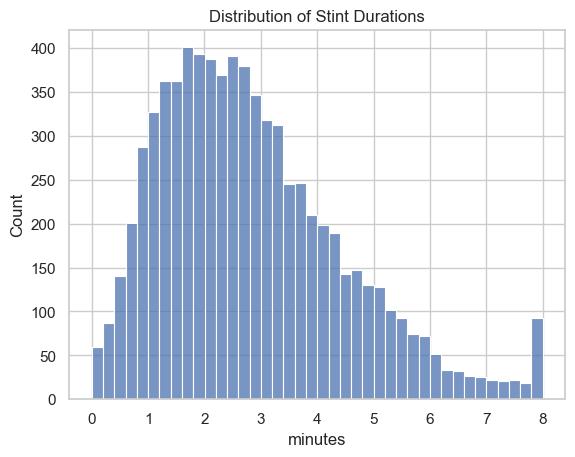

In [7]:
sns.histplot(stints["minutes"], bins=40)
plt.title("Distribution of Stint Durations")
plt.show()


avergae points scored per stint: 8.825859291084855


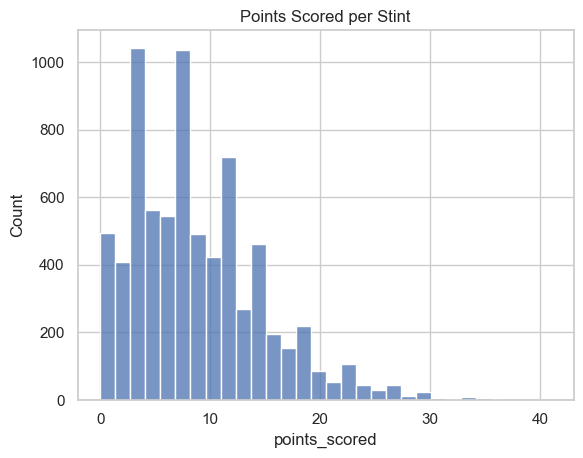

In [8]:

stints["points_scored"] = stints["h_goals"] + stints["a_goals"]
print("avergae points scored per stint:", stints["points_scored"].mean())

sns.histplot(stints["points_scored"], bins=30)
plt.title("Points Scored per Stint")
plt.show()



An Average of 8.8 goals are scored per stint, and it has a lot of variance, so we are curious if this variance can be captured based on looking at which players were on/off and home/away advantages

## Initial Observations

#### Is there enough data?
- Yes there are thousands of stints of data to look at, so we can track performance of different players across enough stints to get a big picture understanding


## CONTINUE...

## 5. Team-Level Performance

Now that we have a good sense of our data, lets dive deeper into team level performance

In [9]:
game_results = []

for _, row in stints.groupby("game_id"):
    game_id = row["game_id"].iloc[0]
    h_team = row["h_team"].iloc[0]
    a_team = row["a_team"].iloc[0]
    
    h_score = row["h_goals"].sum()
    a_score = row["a_goals"].sum()
    
    game_results.append({"game_id": game_id, "team": h_team, "team_score": h_score, "opponent_score": a_score, "home": True})
    game_results.append({"game_id": game_id, "team": a_team, "team_score": a_score, "opponent_score": h_score, "home": False})

game_results = pd.DataFrame(game_results)
game_results["win"] = game_results["team_score"] > game_results["opponent_score"]
game_results.head()


,game_id,team,team_score,opponent_score,home,win
0,1,USA,42,63,True,False
1,1,Japan,63,42,False,True
2,2,USA,45,42,True,True
3,2,Great.Britain,42,45,False,False
4,3,USA,60,28,True,True


In [10]:
team_wins = (
    game_results.groupby("team")["win"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "wins", "count": "games"})
)

team_wins["win_rate"] = team_wins["wins"] / team_wins["games"]
team_wins["team_losses"] = team_wins["games"] - team_wins["wins"]
team_wins.sort_values("win_rate", ascending=False)


,wins,games,win_rate,team_losses
team,,,,
Japan,91,110,0.827273,19
USA,79,110,0.718182,31
France,70,110,0.636364,40
Canada,66,110,0.600000,44
Great.Britain,66,110,0.600000,44
Poland,65,110,0.590909,45
Brazil,63,110,0.572727,47
Denmark,57,110,0.518182,53
Columbia,55,110,0.500000,55


### Observations

- Japan is a clear winner with 91 wins, then USA, France, and Canada

## 6. Home vs Away Advantage

In [11]:

home_away = game_results.groupby("home")["win"].mean()
home_away


home
False    0.428788
True     0.571212
Name: win, dtype: float64

Home Win Rate: 0.5712121212121212
Away Win Rate: 0.4287878787878788


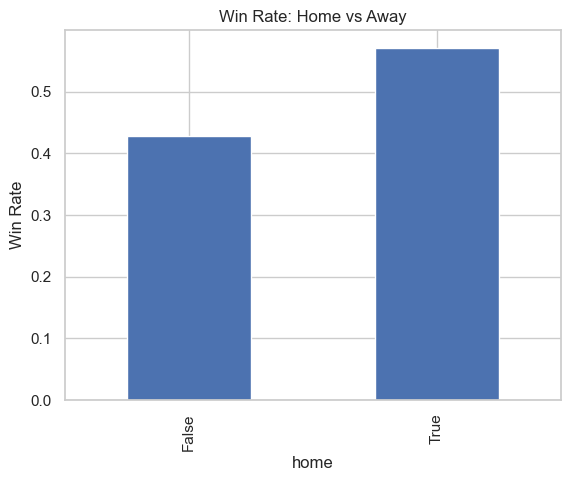

In [12]:

home_away.plot(kind="bar", title="Win Rate: Home vs Away")
print("Home Win Rate:", home_away[True])
print("Away Win Rate:", home_away[False])
plt.ylabel("Win Rate")
plt.show()


### Observations

Playing at home definitely makes a difference, 0.57% win rate at home vs 0.42% win rate away. This means that in our optimization model, we must find a way to account for this bias when we try to optimize the players for maximum wins. This is because the "winning" lineup in the data, may actually be biased by the fact it is a home game, and if that same lineup was played away, it might perform worse than another line-up.

We can:
- Create an optimal line-up per home and away
- Or try to neutralize this bias by including it as some factor in the player optimization model

## 8. Rating vs Performance
Another consideration is how the physical rating effects the performance.

In [15]:
import numpy as np
from collections import defaultdict

home_cols = ["home1","home2","home3","home4"]
away_cols = ["away1","away2","away3","away4"]

# accumulate per-player totals from stints
player_minutes = defaultdict(float)
player_goal_diff = defaultdict(float)

for _, row in stints.iterrows():
    mins = row["minutes"]
    gd = row["h_goals"] - row["a_goals"]

    for p in row[home_cols]:
        player_minutes[p] += mins
        player_goal_diff[p] += gd
    for p in row[away_cols]:
        player_minutes[p] += mins
        player_goal_diff[p] -= gd

player_stats = pd.DataFrame([
    {"player": p,
     "minutes": player_minutes[p],
     "team": p.split("_")[0],
     "lineup_goal_diff_per60": player_goal_diff[p] / player_minutes[p] * 60 if player_minutes[p] > 0 else np.nan}
    for p in player_minutes
])

player_stats = player_stats.merge(players, left_on="player", right_on="player")


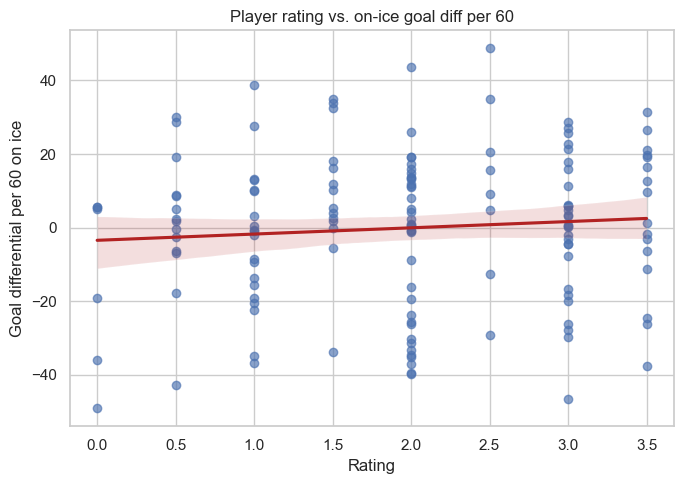

In [17]:
plt.figure(figsize=(7, 5))
sns.regplot(
    data=player_stats,
    x="rating",
    y="lineup_goal_diff_per60",
    scatter_kws={"alpha": 0.65},
    line_kws={"color": "firebrick"},
)
plt.title("Player rating vs. on-ice goal diff per 60")
plt.xlabel("Rating")
plt.ylabel("Goal differential per 60 on ice")
plt.grid(True)
plt.tight_layout()


### Observations

We see that there is somewhat of a difference in goal differential due to rating

## 9. Notes for Next Steps

- Which metrics feel noisy?
- Which teams or players stand out?
- Which constraints matter most for optimization?
- What data might be missing?

_Write your thoughts here._